In [1]:
from qiskit import Aer, execute
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *

from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

import sys
sys.path.append('../')

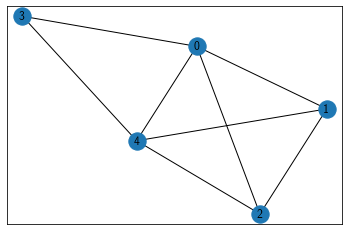

In [2]:
G = nx.read_gml("../data/sample_graphs/er_n5_k4_0.gml")
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=pos)
k_cuts=2

In [3]:
costs=listSortedCosts_MaxCut(G, k_cuts)
costs

{'00000': 0,
 '11111': 0,
 '00010': 2,
 '11101': 2,
 '00100': 3,
 '01000': 3,
 '10111': 3,
 '11011': 3,
 '00001': 4,
 '00011': 4,
 '01100': 4,
 '01101': 4,
 '01111': 4,
 '10000': 4,
 '10010': 4,
 '10011': 4,
 '11100': 4,
 '11110': 4,
 '00101': 5,
 '00110': 5,
 '00111': 5,
 '01001': 5,
 '01010': 5,
 '01011': 5,
 '10100': 5,
 '10101': 5,
 '10110': 5,
 '11000': 5,
 '11001': 5,
 '11010': 5,
 '01110': 6,
 '10001': 6}

In [4]:
good_solutions={}
for key in costs:
    if costs[key]>=5:
        good_solutions[key] = costs[key]

In [5]:
optimal_solutions={}
for key in costs:
    if costs[key]>=6:
        optimal_solutions[key] = 100

In [6]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [7]:
n=12
m=24
beta_max=np.pi/2
gamma_max=np.pi

version=1
circuits=[]
for beta in np.linspace(0,beta_max,n):
    for gamma in np.linspace(0,gamma_max,m):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,k_cuts,version))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v1,_,_ = measurementStatistics_MaxCut(job_sim.result().results, options={'G' : G, 'k_cuts' : k_cuts})

In [8]:
from scipy import optimize as opt

In [9]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,2,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val,_,_=measurementStatistics_MaxCut(j.result().results, options={'G' : G, 'k_cuts' : k_cuts})
    global it, values, gamma, beta
    #print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

Optimization terminated successfully.
         Current function value: -4.767456
         Iterations: 33
         Function evaluations: 64
Optimal value= [0.40680664 0.34160156]


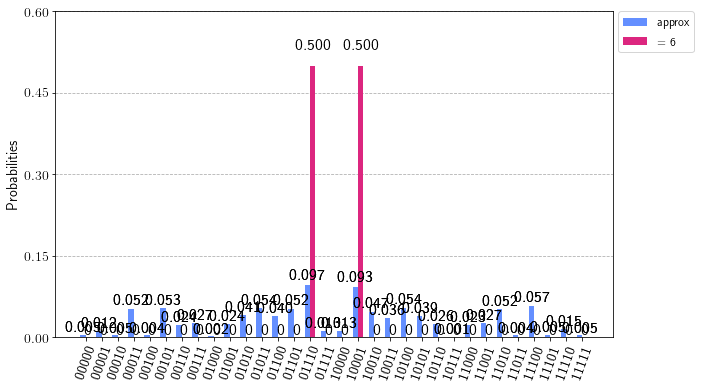

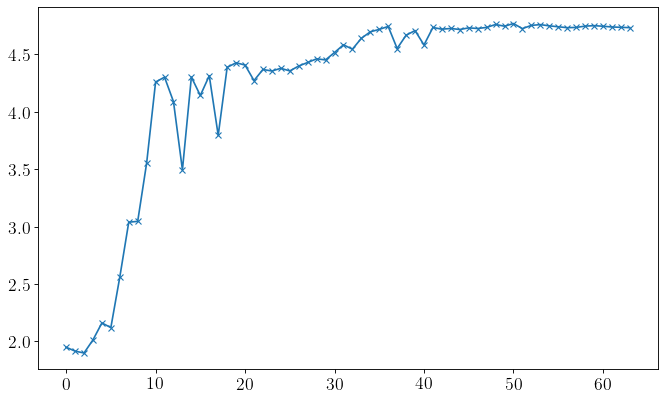

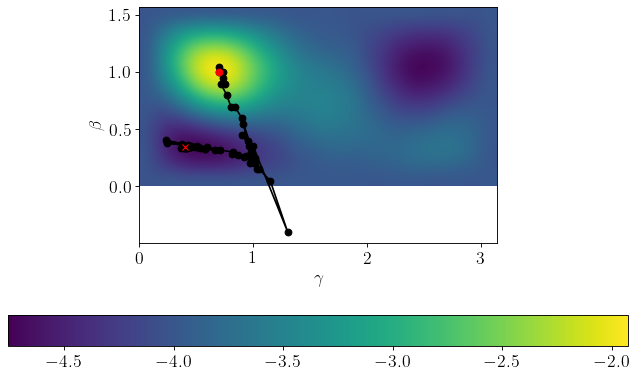

In [10]:
it=0
gamma={}
beta={}
values={}
xin=(.7,1)
out=opt.minimize(getval, x0=xin, method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-1, 'disp': True})
print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(-np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar(orientation="horizontal", pad=0.2)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(xin[0],xin[1],'or')
pl.plot(out.x[0],out.x[1],'xr')

jv1 = execute(createCircuit_MaxCut(out.x,G,1,k_cuts,version), backend_sim, shots=1024*2*2*2)

plot_histogram([jv1.result().get_counts(),optimal_solutions], figsize=(10, 6), legend=['approx',r'$=$ 6'])

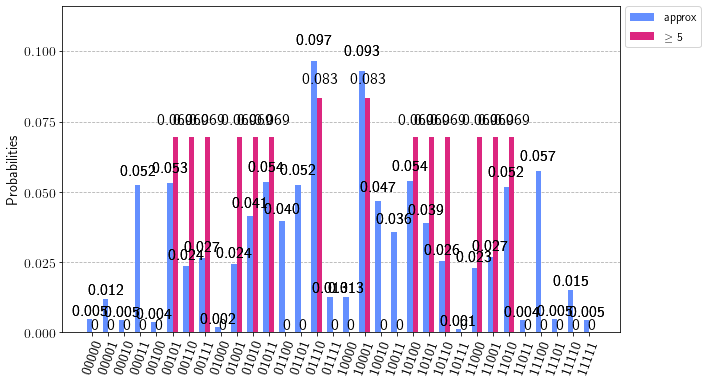

In [11]:
plot_histogram([jv1.result().get_counts(),good_solutions], figsize=(10, 6), legend=['approx',r'$\geq$ 5'])